### Study on bias and interpretable models - SCHOOL PROJECT
*Nathan Lauga - December 2018*

*****

Hello world ! ✋



## Table of content

* [1. Load and prepare data](#1)
    * [1.1 Load libraries](#1.1)
    * [1.2 Load the data](#1.2)
    * [1.3 Quick EDA](#1.3)
    * [1.4 Work with feature](#1.4)
* 2. [AIF360 Introduction](#2)
    * [2.1 Create dataset using aif360](#2.1)
    * [2.2 Quick look on the dataset](#2.2)
    * [2.3 First model](#2.3)
* 3. [Bias and Fairness](#3)
    * [3.1 Metrics](#3.1)
        * [3.1.1 Statistical Parity Difference](#3.1.1)
        * [3.1.2 Equal Opportunity Difference](#3.1.2)
        * [3.1.3 Average Absolute Odds Difference](#3.1.3)
        * [3.1.4 Disparate Impact](#3.1.4)
        * [3.1.5 Theil Index](#3.1.5)
    * [3.2 How to fix it ?](#3.2)
        * [3.2.1 Pre-processing algorithms](#3.2.1)
            * [3.2.1.1 Disparate impact remove](#3.2.1.1)
            * [3.2.1.2 Learning fair representations](#3.2.1.2)
            * [3.2.1.3 Optimized preprocessing](#3.2.1.3)
            * [3.2.1.4 Reweighing](#3.2.1.4)
        * [3.2.2 In-processing algorithms](#3.2.2)
            * [3.2.2.1 Adversarial Debiasing](#3.2.2.1)
            * [3.2.2.2 Prejudice Remover Regularizer](#3.2.2.2)
        * [3.2.3 Post-processing algorithms](#3.2.3)
            * [3.2.3.1 Calibrated Equality of Odds](#3.2.3.1)
            * [3.2.3.2 Equality of Odds](#3.2.3.2)
            * [3.2.3.3 Reject Option Classification](#3.2.3.3)
    * [3.3 Compare all the algorithms for one attribute](#3.3)
    * [3.4 Find the fairest algorithm](#3.4)
    * [3.5 Compare algorithms performance](#3.5)
* 4. [Interpretable model](#4)
    * [4.1 Feature importance](#4.1)
    * [4.2 LIME](#4.2)
    * [4.3 SHAP](#4.3)
* 5. [Conclusion](#5)

## <a id='1'>1. Load and prepare data</a>

### <a id='1.1'>1.1 Load libraries</a>

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# Custom visualisation functions in visualitions.py file
from visualisations import plot_fair_metrics, plot_bar, plot_histo, plot_model_performance, plot_fair_metrics_plotly, plot_score_fair_metrics

# Custom metrics functions in metrics.py file
from metrics import fair_metrics, get_model_performance, score_fair_metrics, score_all_attr

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

import lime
import lime.lime_tabular
import shap

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

### <a id='1.2'>1.2 Load the data</a>

I choose to use the Adult dataset that you can find on the following link : [UCI Machine Learning Repository : Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult)

In [5]:
cols = ["Age", "Workclass", "Final Weight", "Education", "Education-Num", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country", "Income"]
data = pd.read_csv('./data/adult.csv', header=None)
data.columns = cols

### <a id='1.3'>1.3 Quick EDA</a>

In [6]:
data.head()

Age          Workclass  Final Weight   Education  Education-Num  \
0   39          State-gov         77516   Bachelors             13   
1   50   Self-emp-not-inc         83311   Bachelors             13   
2   38            Private        215646     HS-grad              9   
3   53            Private        234721        11th              7   
4   28            Private        338409   Bachelors             13   

        Marital Status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital Gain  Capital Loss  Hours per week         Country  Income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

Since Education-Num is the same as Education but classed by number we can drop it

In [7]:
data.drop(columns=['Education-Num'], inplace=True)

In [8]:
na_count = pd.DataFrame(data.apply(lambda x : x.isna()).sum()).transpose()
na_count

Age  Workclass  Final Weight  Education  Marital Status  Occupation  \
0    0          0             0          0               0           0   

   Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0             0     0    0             0             0               0   

   Country  Income  
0        0       0

This dataset doesn't have any NA value so we don't have to work with that.

#### Continuous columns

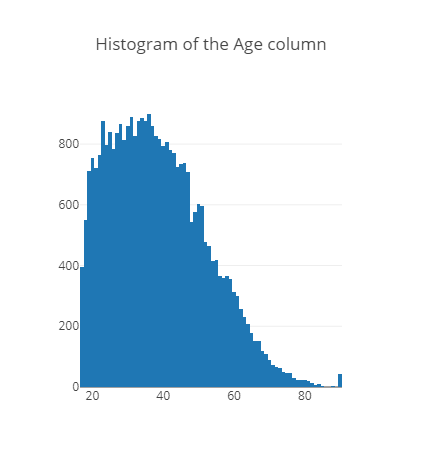

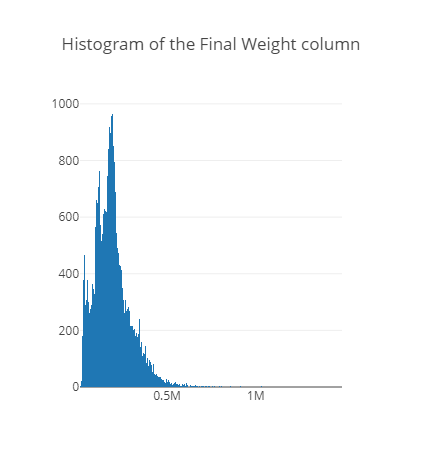

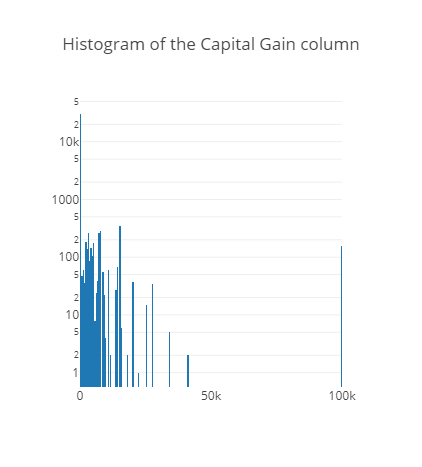

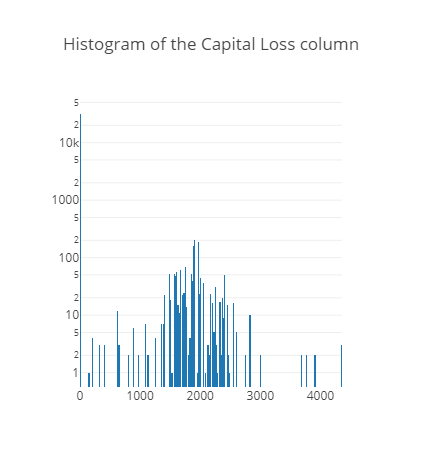

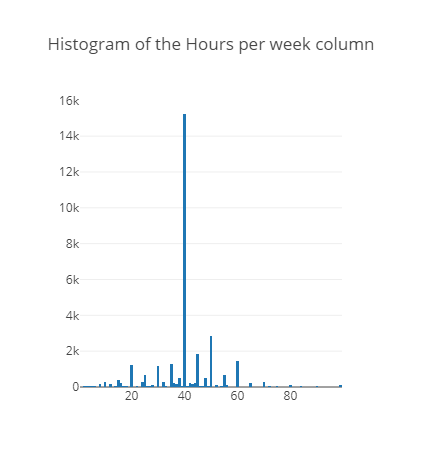

In [6]:
# print(data.columns.values)
display(Markdown('#### Continuous columns'))
plot_histo(data, 'Age')
plot_histo(data, 'Final Weight')
plot_histo(data, 'Capital Gain', type='log')
plot_histo(data, 'Capital Loss', type='log')
plot_histo(data, 'Hours per week')

#### Categorical columns

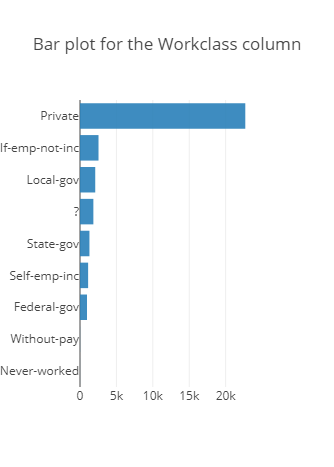

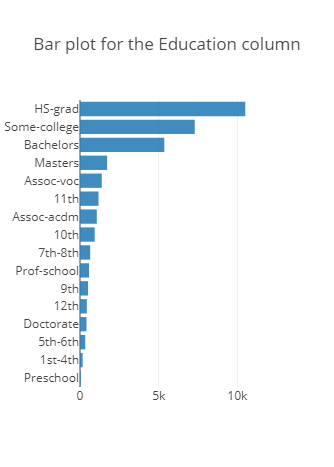

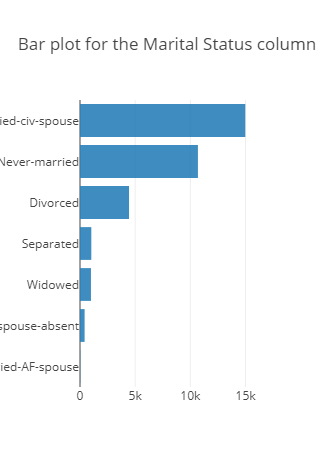

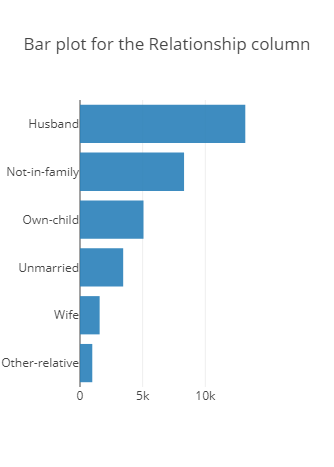

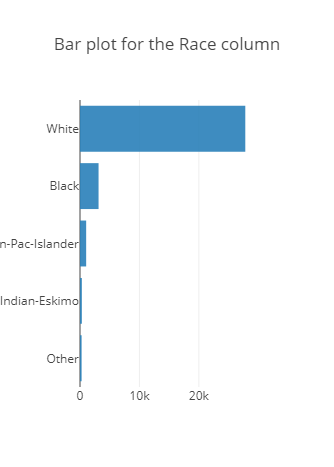

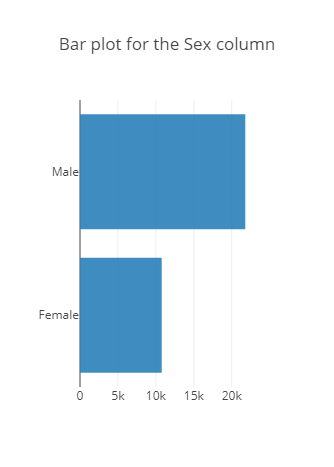

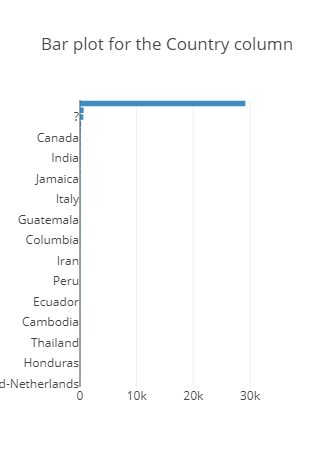

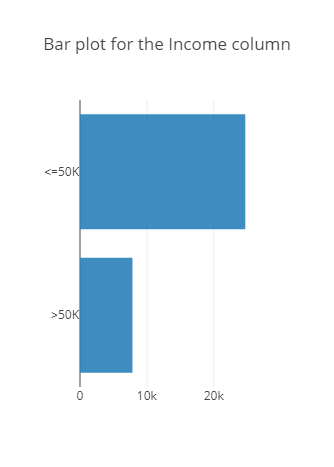

In [253]:
display(Markdown('#### Categorical columns'))
plot_bar(data, 'Workclass')
plot_bar(data, 'Education')
plot_bar(data, 'Marital Status')
plot_bar(data, 'Relationship')
plot_bar(data, 'Race')
plot_bar(data, 'Sex')
plot_bar(data, 'Country')
plot_bar(data, 'Income')

### <a id='1.4'>1.4 Work with feature</a>

#### Encoding categorical columns

*Why encoding and not dummies ?*

Later in the notebook I will use lime and shap libraries to interpret the model but with dummies values it just get the data to be incoherent (I will explain it later).

In [9]:
categorical_features = ["Workclass", "Education", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Country", "Income"]
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

numerical_features = [c for c in data.columns.values if c not in categorical_features]

In [10]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le
    
for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    data_encoded[feature] = MinMaxScaler().fit_transform(val)
    
data_encoded = data_encoded.astype(float)

In [11]:
data_encoded.head()

Age  Workclass  Final Weight  Education  Marital Status  Occupation  \
0  0.301370        7.0      0.044302        9.0             4.0         1.0   
1  0.452055        6.0      0.048238        9.0             2.0         4.0   
2  0.287671        4.0      0.138113       11.0             0.0         6.0   
3  0.493151        4.0      0.151068        1.0             2.0         6.0   
4  0.150685        4.0      0.221488        9.0             2.0        10.0   

   Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0           1.0   4.0  1.0       0.02174           0.0        0.397959   
1           0.0   4.0  1.0       0.00000           0.0        0.122449   
2           1.0   4.0  1.0       0.00000           0.0        0.397959   
3           0.0   2.0  1.0       0.00000           0.0        0.397959   
4           5.0   2.0  0.0       0.00000           0.0        0.397959   

   Country  Income  
0     39.0     0.0  
1     39.0     0.0  
2     39.0     0.0  
3     39.0     0.0  
4      5.0     0.0

## <a id='2'>2. AIF360 Introduction</a>
### <a id='2.1'>2.1 Create dataset using aif360</a>

In [12]:
privileged_sex = np.where(categorical_names['Sex'] == ' Male')[0]
privileged_race = np.where(categorical_names['Race'] == ' White')[0]

In [13]:
data_orig = StandardDataset(data_encoded, 
                           label_name='Income', 
                           favorable_classes=[1], 
                           protected_attribute_names=['Sex', 'Race'], 
                           privileged_classes=[privileged_sex, privileged_race])

### <a id='2.2'>2.2 Quick look on the dataset</a>

In [14]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(data_orig.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(data_orig.favorable_label, data_orig.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(data_orig.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(data_orig.privileged_protected_attributes, data_orig.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(data_orig.feature_names)

#### Dataset shape

(32561, 13)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Sex', 'Race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([4.])] [array([0.]), array([0., 1., 2., 3.])]


#### Dataset feature names

['Hours per week', 'Country', 'Education', 'Final Weight', 'Race', 'Marital Status', 'Age', 'Sex', 'Capital Gain', 'Workclass', 'Occupation', 'Relationship', 'Capital Loss']


### <a id='2.3'>2.3 First model</a>

#### Split into train and test set

In [15]:
np.random.seed(42)

data_orig_train, data_orig_test = data_orig.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print(data_orig_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print(data_orig_test.features.shape)

#### Train Dataset shape

(22792, 13)


#### Test Dataset shape

(9769, 13)


#### Training the model : classic Random Forest 

In [16]:
def train_model(model, dataset):
    X_train = dataset.features
    y_train = dataset.labels.ravel()
    
    # Train the model
    model.fit(X_train, y_train, sample_weight=dataset.instance_weights)
    
    return model

# Model to learn
rf = RandomForestClassifier(n_estimators=100)

# Train and save the model
rf_orig = train_model(rf, data_orig_train)

#### Predict on test set

In [17]:
X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()

Now we have a model (Random forest) that is trained with the training dataset and the prediction of the test set. So in a first place let's check the performance of our model (accuracy, F1 Score, confusion matrix, ...).

#### Performance of the model

#### Accuracy of the model :

0.8594533729143208


#### F1 score of the model :

0.6813645857507543


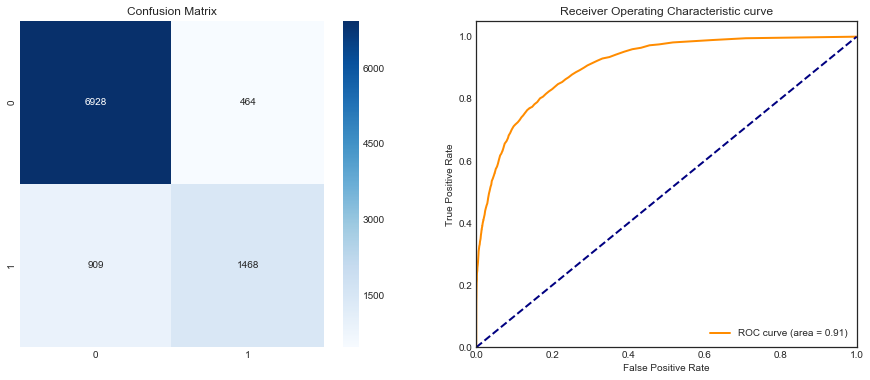

In [18]:
plot_model_performance(rf_orig, data_orig_test.features, y_test)

## <a id='3'>3. Bias and Fairness</a>

Today, a problem of the model that can be produce by Machine Learning is bias that data can have. So a question is how to measure those bias and how to avoid them. In python there is a package produced by IBM called [aif360](https://github.com/IBM/AIF360) that can gives us some metrics and algorithms to know if our data / model are bias and to get a fair model.

### <a id='3.1'>3.1 Metrics</a>

So with aif360 we have some metrics that indicate if our data or model are bias. I will use 5 metrics : 
* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

#### <a id='3.1.1'>3.1.1 Statistical Parity Difference</a>

This measure is based on the following formula : 

$$ Pr(Y=1|D=unprivileged) - Pr(Y=1|D=privileged) $$

Here the bias or *statistical imparity* is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1.

So it has to be close to **0** so it will be fair.

Also you can find more details about that here : [One definition of algorithmic fairness: statistical parity](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)


#### <a id='3.1.2'>3.1.2 Equal Opportunity Difference</a>

This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula :

$$ TPR_{D=unprivileged} - TPR_{D=privileged} $$ 

Same as the previous metric we need it to be close to **0**.

#### <a id='3.1.3'>3.1.3 Average Absolute Odds Difference</a>

This measure is using both false positive rate and true positive rate to calculate the bias. It's calculating the equality of odds with the next formula :

$$ \frac{1}{2}[|FPR_{D=unprivileged} - FPR_{D=privileged} | + | TPR_{D=unprivileged} - TPR_{D=privileged}|]$$

It needs to be equal to **0** to be fair.

#### <a id='3.1.4'>3.1.4 Disparate Impact</a>

For this metric we use the following formula :

$$ \frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)} $$

Like the first metric we use both probabities of a random individual drawn from unprivileged or privileged with a label of 1 but here it's a ratio. 

It changes the objective, for the disparate impact it's **1** that we need.

#### <a id='3.1.5'>3.1.5 Theil Index</a>

This measure is also known as the generalized entropy index but with $\alpha$ equals to 1 (more informations on [the Wikipedia page](https://en.wikipedia.org/wiki/Generalized_entropy_index)). So we can calculate it with this formula :

$$ \frac{1}{n} \sum_{i=0}^{n} \frac{b_i}{\mu} ln \frac{b_i}{\mu} $$ 

Where $b_i = \hat{y}_i - y_i + 1 $

So it needs to be close to **0** to be fair.


With these differents metrics we can see that for some we need the prediction and for others just the original dataset. This is why we will use 2 classes of the aif360 package : `ClassificationMetric` and `BinaryLabelDatasetMetric`. 

For the first one we need the prediction so we can have the following metrics : 
* Equal Opportunity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.equal_opportunity_difference)
   
`equal_opportunity_difference()`
* Average Absolute Odds Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.average_abs_odds_difference)

`average_abs_odds_difference()`
* Theil Index : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.theil_index)

`theil_index()`

Then for the metrics that don't require prediction (the second class) we can use them with the following functions : 
* Statistical Parity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.BinaryLabelDatasetMetric.statistical_parity_difference)

`statistical_parity_difference()`
* Disparate Impact : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.disparate_impact)

`disparate_impact()`


Now I construct a `DataFrame` that will keep the values of the differents metrics I talked just above with a function. 

In [19]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Sex attribute :

With default thresholds, bias against unprivileged group detected in **2** out of 5 metrics

#### For the Race attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

statistical_parity_difference  equal_opportunity_difference  \
objective                       0.000000                      0.000000   
Sex                            -0.177434                     -0.092290   
Race                           -0.138828                     -0.400577   

           average_abs_odds_difference  disparate_impact  theil_index  
objective                     0.000000          1.000000      0.00000  
Sex                           0.082224          0.308369      0.11561  
Race                          0.207058          0.347926      0.11561

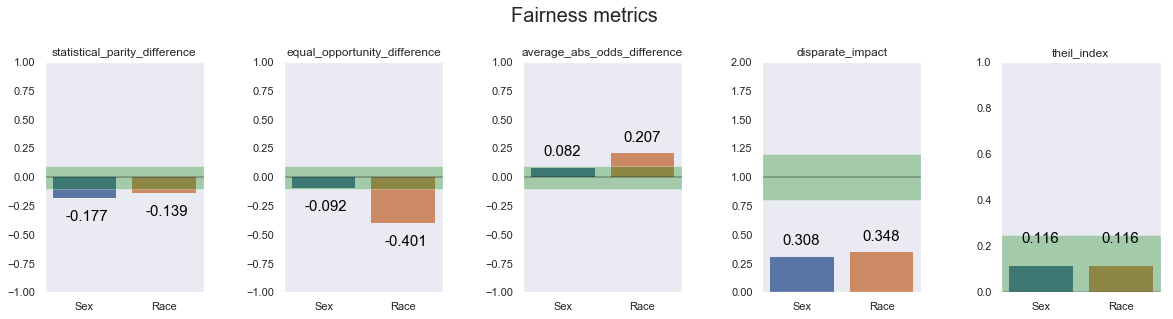

In [20]:
fair = get_fair_metrics_and_plot(data_orig_test, rf_orig)

In [21]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [22]:
probs = rf.predict_proba(data_orig_test.features)
preds = rf.predict(data_orig_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

As we can see, this first model is biased. The next step is to answer the question : How to fix it ?

### <a id='3.2'>3.2 How to fix it ?</a>

AIF360 use 3 types of algorithms :
* Pre-processing algorithms : they are used before training the model
* In-processing algorithms : they are fair classifiers so it's during the training
* Post-processing algorithms : they are used after training the model

![Fairness pipeline](http://image.noelshack.com/fichiers/2018/50/1/1544437769-fairness-pipeline.png)

This is the **fairness pipeline**. An example instantiation of this generic pipeline consists of loading data into a dataset object, transforming
it into a fairer dataset using a fair pre-processing algorithm, learning a classifier from this transformed dataset, and obtaining
predictions from this classifier. Metrics can be calculated on the original, transformed, and predicted datasets as well as between the
transformed and predicted datasets. Many other instantiations are also possible (more information on [the aif360 paper](https://arxiv.org/pdf/1810.01943.pdf)).

#### <a id='3.2.1'>3.2.1 Pre-processing algorithms </a>

There are 4 pre-processing algorithms but for 3 of them **there is a problem** : it will work only if the dataset have one protected attribute but here we have 2 : *Sex* and *Race*. But let's have a quick intro for all of them and at the end I will use the one that work for my case.

Because this notebook is an exploration of fairness into models I will only use 1 protected attribute : Sex, it will allow me to use almost all the algorithms (but for your information the *Reweighing* algo can works with all protected so that's why I will create a function that gives me the protected and unprotected attributes.

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html#)



In [23]:
def get_attributes(data, only_one=True):
    unprivileged_groups = []
    privileged_groups = []
    
    for attr in data.protected_attribute_names:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]}) 
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]}) 
            if only_one:
                break

    return privileged_groups, unprivileged_groups

*****
##### <a id='3.2.1.1'>3.2.1.1 Disparate impact remover</a>
Source : [Feldman et al., 2015](https://dl.acm.org/citation.cfm?doid=2783258.2783311)

Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups.
If you want to see how it works you can take a look on [an example Notebook from the GitHub of AIF360](https://github.com/IBM/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb).

Some code example :
```
from aif360.algorithms.preprocessing import DisparateImpactRemover
DIR = DisparateImpactRemover()
data_transf_train = DIR.fit_transform(data_orig_train)
```
*****
##### <a id='3.2.1.2'>3.2.1.2 Learning fair representations</a>
Source : [Zemel et al., 2013](http://proceedings.mlr.press/v28/zemel13.html)

Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes.
You can find more information on [the demo notebook](https://github.com/IBM/AIF360/blob/master/examples/demo_lfr.ipynb).

In [24]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

LFR = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=1, verbose=0)
# LFR.fit(data_orig_train)
data_transf_train = LFR.fit_transform(data_orig_train)

# Train and save the model
rf_transf = train_model(rf, data_transf_train)

data_transf_test = LFR.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)

# algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, 'LFR')

250 nan
500 nan
750 nan


*****
##### <a id='3.2.1.3'>3.2.1.3 Optimized preprocessing</a>
Source : [Calmon et al., 2017](http://papers.nips.cc/paper/6988-optimized-pre-processing-for-discrimination-prevention)

Optimized preprocessing is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives.
There is also [a demo notebook on the aif360 GitHub](https://github.com/IBM/AIF360/blob/master/examples/demo_optim_data_preproc.ipynb).

*To be honest I tried to work with this one but it's more complicated : it uses options that you have to configure yourself and I don't really find how to choose it. Also it use an Optimizer and I didn't find how to build this class. (I didn't read the paper about this algorithm)*
*****
##### <a id='3.2.1.4'>3.2.1.4 Reweighing</a>
Source : [Kamiran and Calders, 2012](https://link.springer.com/article/10.1007%2Fs10115-011-0463-8)

Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification.

In [25]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=False)

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
rf_transf = train_model(rf, data_transf_train)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_orig_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'Reweighing')

#### <a id='3.2.2'>3.2.2 In-processing algorithms</a>

It exists 3 in-processing algorithms with aif360. But **I will only use 2** : *Adversarial Debiasing* wich is using TensorFlow and *Prejudice Remover Regularizer*. I'm not using the last one : *ART Classifier*, because I didn't found any documentation that show how it works (maybe I didn't search enough 🙄).

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/inprocessing.html)
*****
#####  <a id='3.2.2.1'>3.2.2.1 Adversarial Debiasing</a>
Source : [Zhang et al., 2018](http://www.aies-conference.com/wp-content/papers/main/AIES_2018_paper_162.pdf)

Adversarial debiasing is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary’s ability to determine the protected attribute from the predictions. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit.

In [27]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

# sess.close()
# tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          num_epochs=42,
                          debias=True,
                          sess=sess)

debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'AdvDebiasing')

epoch 0; iter: 0; batch classifier loss: 1.649492; batch adversarial loss: 0.695595
epoch 1; iter: 0; batch classifier loss: 0.986846; batch adversarial loss: 0.997370
epoch 2; iter: 0; batch classifier loss: 0.878605; batch adversarial loss: 0.847384
epoch 3; iter: 0; batch classifier loss: 0.857240; batch adversarial loss: 0.723975
epoch 4; iter: 0; batch classifier loss: 0.559571; batch adversarial loss: 0.620674
epoch 5; iter: 0; batch classifier loss: 0.463991; batch adversarial loss: 0.660357
epoch 6; iter: 0; batch classifier loss: 0.447209; batch adversarial loss: 0.632340
epoch 7; iter: 0; batch classifier loss: 0.389001; batch adversarial loss: 0.606716
epoch 8; iter: 0; batch classifier loss: 0.395770; batch adversarial loss: 0.616748
epoch 9; iter: 0; batch classifier loss: 0.349415; batch adversarial loss: 0.650611
epoch 10; iter: 0; batch classifier loss: 0.444998; batch adversarial loss: 0.571459
epoch 11; iter: 0; batch classifier loss: 0.453961; batch adversarial loss:

*****
##### <a id='3.2.2.2'>3.2.2.2 Prejudice Remover Regularizer</a>
Source : [Kamishima et al., 2012](https://rd.springer.com/chapter/10.1007/978-3-642-33486-3_3)

Prejudice remover is an in-processing technique that adds a discrimination-aware regularization term to the learning objective.

In [28]:
debiased_model = PrejudiceRemover(sensitive_attr="Sex", eta = 25.0)
debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'PrejudiceRemover')

#### <a id='3.2.3'>3.2.3 Post-processing algorithms</a>

It exists 3 post-processing algorithms with aif360. 

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/postprocessing.html)

I prepare the predict dataset for all the algorithms that require a dataset with predict scores and labels.

In [29]:
data_orig_test_pred = data_orig_test.copy(deepcopy=True)

# Prediction with the original RandomForest model
scores = np.zeros_like(data_orig_test.labels)
scores = rf.predict_proba(data_orig_test.features)[:,1].reshape(-1,1)
data_orig_test_pred.scores = scores

preds = np.zeros_like(data_orig_test.labels)
preds = rf.predict(data_orig_test.features).reshape(-1,1)
data_orig_test_pred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

*****
##### <a id='3.2.3.1'>3.2.3.1 Calibrated Equality of Odds</a>
Source : [Pleiss et al., 2017](https://papers.nips.cc/paper/7151-on-fairness-and-calibration)

Calibrated equalized odds postprocessing is a post-processing technique that optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective.

In [30]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

cost_constraint = "fnr" # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = CPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_orig_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      CPP, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'CalibratedEqOdds')

*****
##### <a id='3.2.3.2'>3.2.3.2 Equality of Odds</a>
Source : [Hardt et al., 2016](https://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning)

Equalized odds postprocessing is a post-processing technique that solves a linear program to find probabilities with which to change output labels to optimize equalized odds.

In [31]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

EOPP = EqOddsPostprocessing(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups,
                             seed=42)

EOPP = EOPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = EOPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      EOPP, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'EqOdds')

*****
##### <a id='3.2.3.3'>3.2.3.3 Reject Option Classification</a>
Source : [Kamishima et al., 2012](https://ieeexplore.ieee.org/document/6413831/)

Reject option classification is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

In [32]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

ROC = RejectOptionClassification(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups)

ROC = ROC.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = ROC.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      ROC, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'RejectOption')

### <a id='3.3'>3.3 Compare all the algorithms for one attribute</a>

In [35]:
def compare_fair_metrics(algo_metrics, attr='Sex'):
    
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    
    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score)

statistical_parity_difference  equal_opportunity_difference  \
Origin                                -0.177434                     -0.092290   
Reweighing                            -0.175929                     -0.098931   
AdvDebiasing                          -0.001855                      0.339734   
PrejudiceRemover                      -0.163178                     -0.263306   
CalibratedEqOdds                      -0.175929                     -0.098931   
EqOdds                                -0.025396                      0.111929   
RejectOption                          -0.046211                      0.226417   

                  average_abs_odds_difference  disparate_impact  theil_index  
Origin                               0.082224          0.308369     0.115610  
Reweighing                           0.084211          0.302583     0.116129  
AdvDebiasing                         0.175757          0.985841     0.181555  
PrejudiceRemover                     0.174202          0.088076     0.189803  
CalibratedEqOdds                     0.084211          0.302583     0.116129  
EqOdds                               0.074382          0.854334     0.164988  
RejectOption                         0.116995          0.715999     0.144939

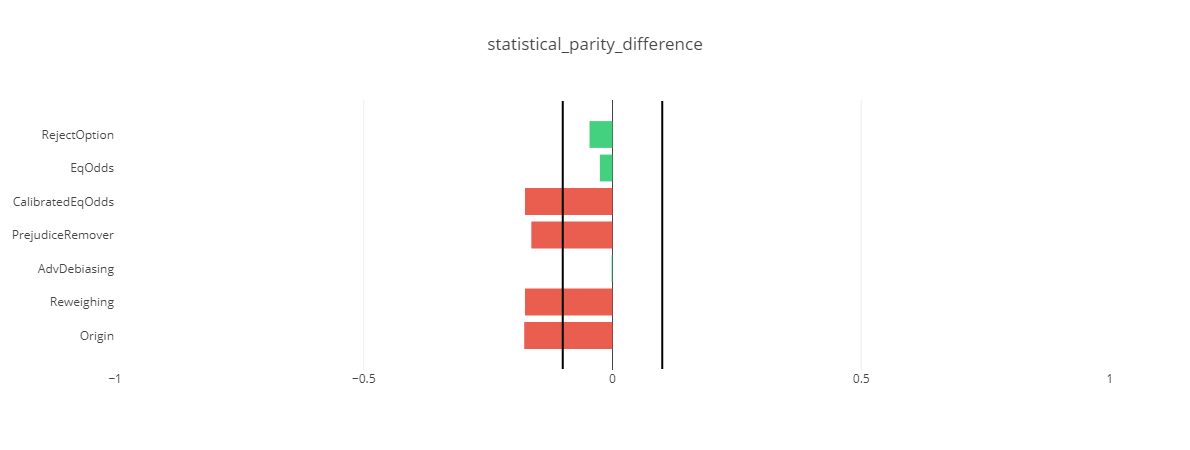

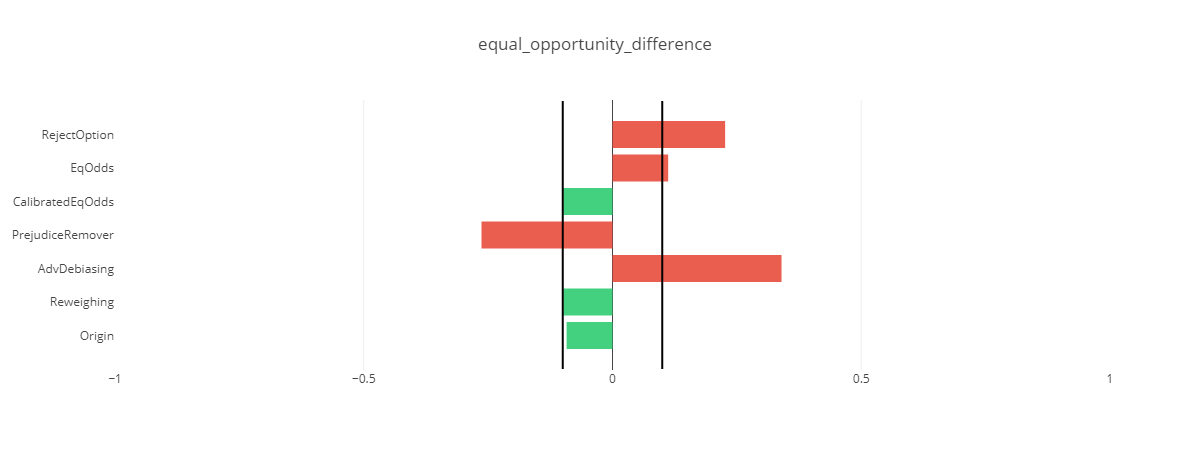

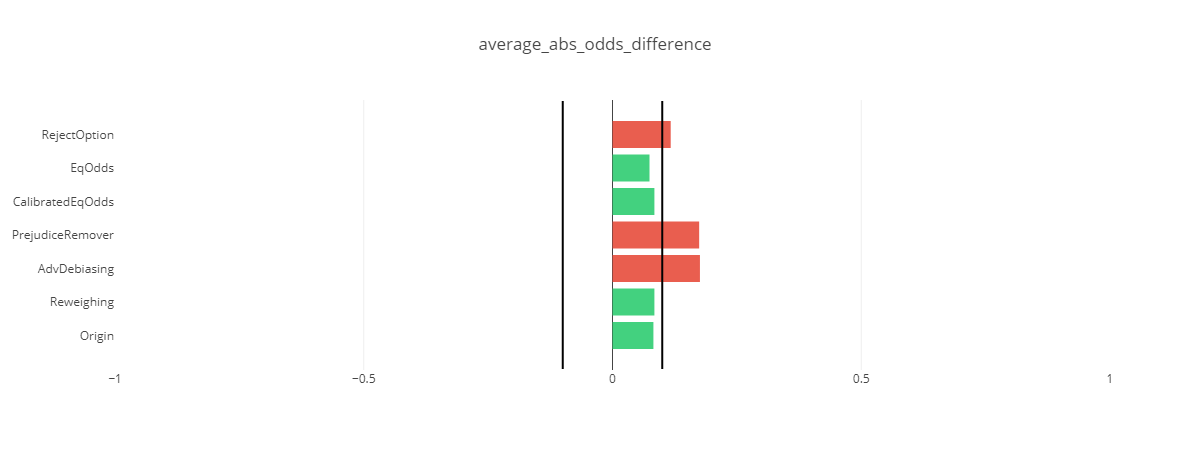

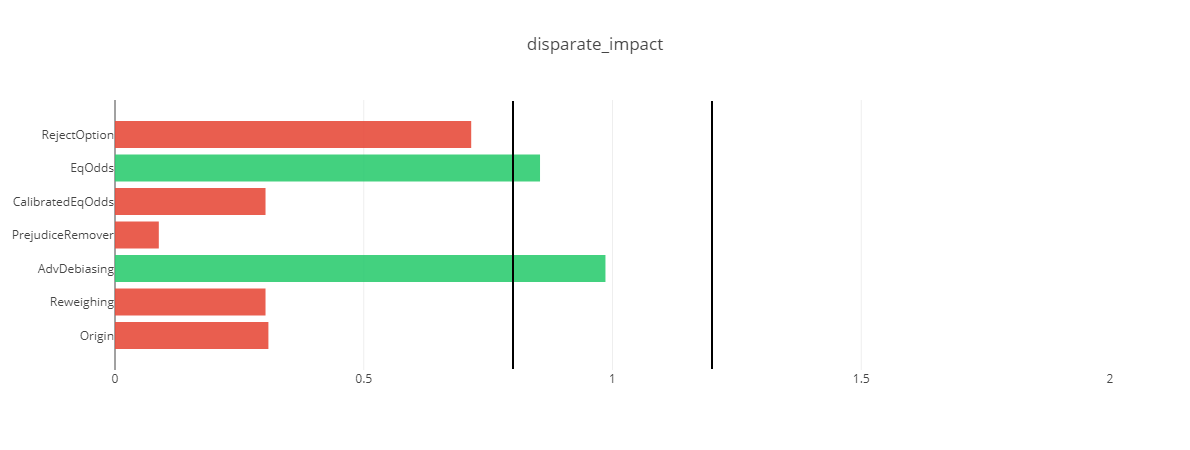

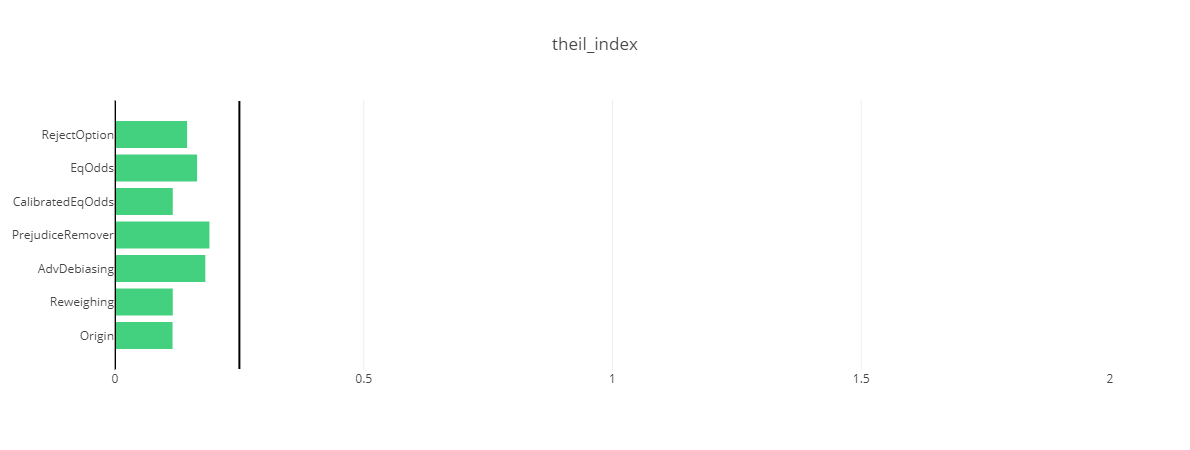

score  nb_valid
EqOdds            0.522363       4.0
AdvDebiasing      0.713061       3.0
Origin            1.159189       3.0
Reweighing        1.172618       3.0
CalibratedEqOdds  1.172618       3.0
RejectOption      0.818564       2.0
PrejudiceRemover  1.702411       1.0

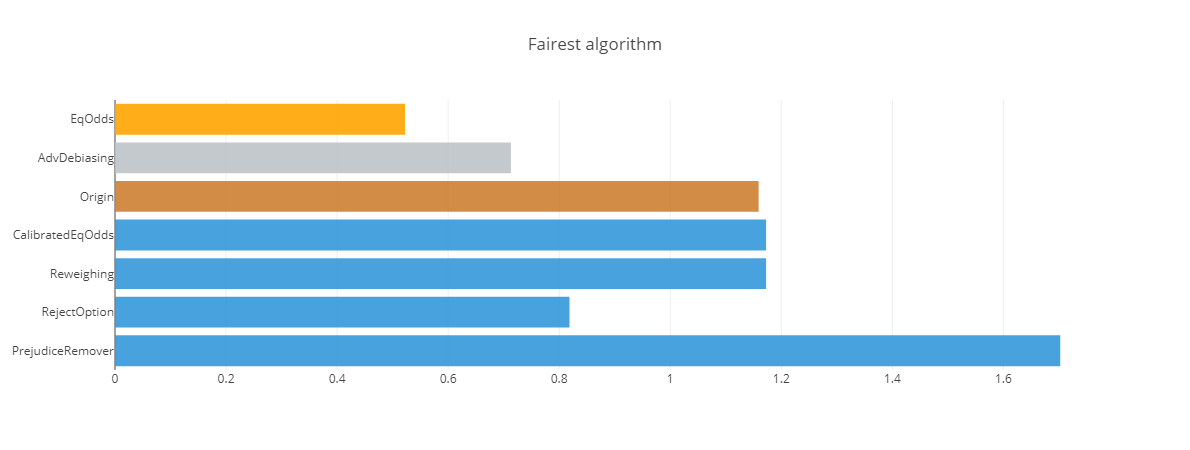

In [36]:
compare_fair_metrics(algo_metrics)

### <a id='3.4'>3.4 Find the fairest algorithm</a>

score  nb_valid
EqOdds            1.633473       6.0
AdvDebiasing      1.971067       6.0
RejectOption      2.078115       4.0
Origin            2.673335       4.0
Reweighing        2.826540       4.0
CalibratedEqOdds  2.826540       4.0
PrejudiceRemover  2.864285       3.0

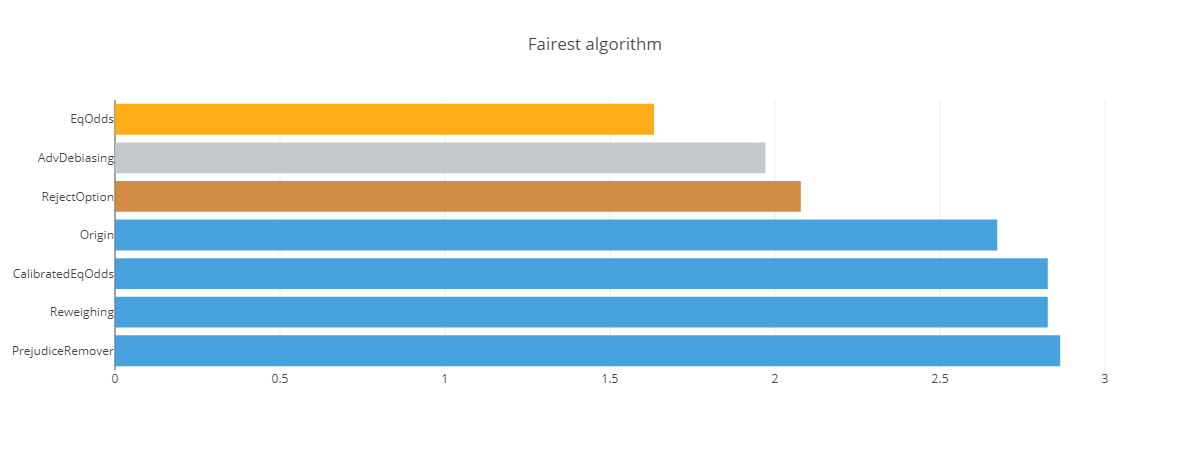

In [37]:
final = score_all_attr(algo_metrics)
plot_score_fair_metrics(final)

So now we see that it's the **EqOdds** algorithm that gives us the fairest model but it's not completly fair only 6 metrics for 10 valid the fair of the model, mostly for the *Race* column because we didn't unbias the column, but for the *Sex* column we can see that 4 metrics valid fair in the model so it's a great improvment ! 👍

Now let's compare our algorithm for the performance.

### <a id='3.5'>3.5 Compare algorithms performance</a>

Accuracy  F1 Score
Reweighing        0.860784  0.681648
CalibratedEqOdds  0.860784  0.681648
Origin            0.859453  0.681365
RejectOption      0.846555  0.607283
EqOdds            0.810216  0.536268
PrejudiceRemover  0.800491  0.458160

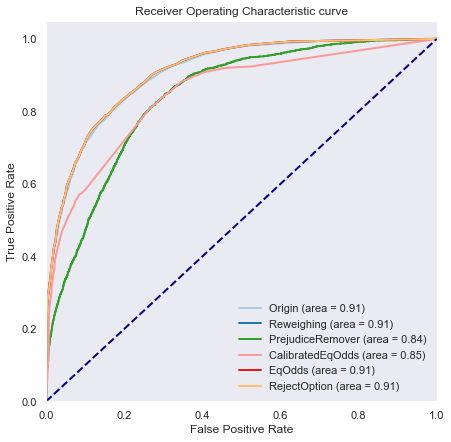

In [39]:
plot_compare_model_performance(algo_metrics)

We can see that the original model still has the best accuracy and F1 Score. I remind you that here I didn't optimize the models to be excellent I used default configurations.

Now you have to ask yourself the question, **what is more important : performance or fair ?**

## <a id='4'>4. Interpretable model</a>
### <a id='4.1'>4.1 Feature importance</a>

The question of **model interpretation is becoming really important** and the most common way to explain a model is to use **feature importance**. It's usefull to get an insight of what the model is using in feature to predict something but it has limits. First of all let's see how it works.

Feature importance changes according to the model that we're using. It's important to know that **it exists differents ways to measure feature importance** according to the model so I will introduce some measure for 3 types of models : Linear Regression, Decision Tree and Tree models.

#### <a id='4.1.1'>4.1.1 Linear Regression</a>

For the Linear Regression if we have standardized the features the coefficient represents the influence of the feature on the model. So for a Linear model with a formula : 

$$h_\theta(X) = \theta_0x_0 + \theta_1x_1 + ... + + \theta_nx_n = \theta^TX$$

We can just take all the theta with the vector $\theta$ and it's our importance for each feature.

#### <a id='4.1.2'>4.1.2 Decision Tree</a>

For the Decision Tree, feature importance is not really important because this model is human interpretable. For a prediction you just have to follow the leaves.

#### <a id='4.1.3'>4.1.3 Tree models (e.g Random Forest)</a>

I think this type of models (Random Forest, XGBoost, LGBM, ...) is well known in the industry today so the feature importance of those models are logically the most used for classification. So the most used measure of feature importance for Tree models is **Gini Importance or Mean Decrease in Impurity (MDI)**. 

![Random Forest](https://cdn-images-1.medium.com/max/1000/1*xxahsU68wsbXyMYAFTf-Eg.png)

**MDI** counts the times a feature is used to split a node, weighted by the number of samples it splits.

We can calculate it with this formula :

$$Imp(X_j)=\frac{1}{M}\sum_{m=1}^{M}\sum_{t\in \varphi_m} (j_t=j)[p(t)\Delta i(t)]$$

Here we calculate the importance of variable $X_j$ for an ensemble of $M$ trees. $j_t$ denotes the variable used at node $t$, $p(t) = \frac{N_t}{N}$ is the proportion of rows used in that node (if it's the first node it will be 1) and $\Delta i(t)$ is the impurity reduction at node $t$ : we can use Gini index or Entropy to measure impurity.

I find out this formula from this course : [Understanding variable importances in forests of randomized trees](https://fr.slideshare.net/glouppe/understanding-variable-importances-in-forests-of-randomized-trees)

Also if you want more informations about others Tree models measure of feature importance you can take a look at this publication : [Feature Importance Measures for Tree Models — Part I](https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3)

Now let's see what is the feature importance of our Random Forest model.

In [158]:
rf.feature_importances_
feature_imp = pd.Series(rf.feature_importances_, index=data_orig_train.feature_names)
feature_imp.sort_values(ascending=False, inplace=True)

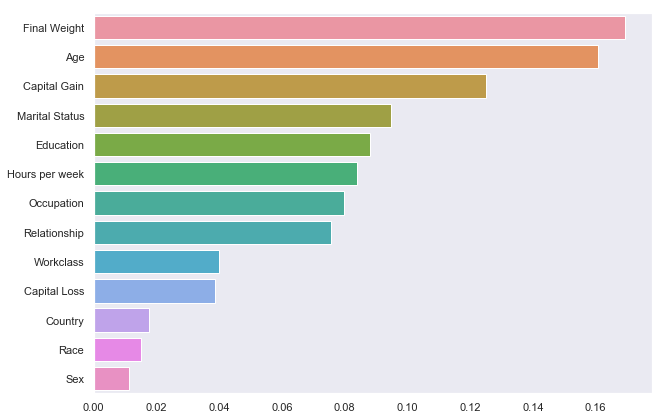

In [159]:
plt.figure(figsize=(10,7))
ax = sns.barplot(y=feature_imp.index.values, x=feature_imp,orient='h')

We see that *Final Weight*, *Age* and *Capital Gain* are the features that are the most importance for this model if we use feature importance from sklearn RandomForestClassifier. But now we arrive at **the limits of feature importance**, if I want to know wich feature are important on **a specific prediction** I can't know that I just can suppose that it follows the feature importance measure but I can not be sure.

### 4.2 LIME

In [160]:
test_interp = pd.DataFrame(data=data_orig_test.features,
                            columns=data_orig_test.feature_names)

categorical_features = ["Workclass", "Education", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Country"]
categorical_features_idx = [np.where(test_interp.columns.values == col)[0][0] for col in categorical_features]
categorical_names_LIME = {}

for feature, idx in zip(categorical_features, categorical_features_idx):
    categorical_names_LIME[idx] = categorical_names[feature]

explainer = lime.lime_tabular.LimeTabularExplainer(test_interp.values,
                                                   feature_names=test_interp.columns.values,
                                                   class_names=['Income <= 50K', 'Income > 50K'],
                                                   categorical_features=categorical_features_idx, 
                                                   categorical_names=categorical_names_LIME)

row = pd.DataFrame(data=[test_interp.iloc[2,:]], columns=test_interp.columns.values)
display(row)

exp = explainer.explain_instance(row.values[0], rf.predict_proba, num_features=7)
exp.show_in_notebook(show_table=True, show_all=False)

Relationship  Education  Race  Capital Gain  Hours per week  Occupation  \
2           5.0       15.0   4.0           0.0         0.44898         0.0   

   Country  Final Weight  Workclass       Age  Capital Loss  Marital Status  \
2     39.0      0.115729        0.0  0.616438           0.0             2.0   

   Sex  
2  0.0

### 4.3 SHAP

In [161]:
t0 = time()
print('start : %0.4f'%((time() - t0)))

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)
print('explainer end : %0.4f'%((time() - t0)))

# Calculate Shap values
test = test_interp.iloc[0:10,:]
shap_values = explainer.shap_values(test)
print('shap values end : %0.4f'%((time() - t0)))

start : 0.0000
explainer end : 0.0958
shap values end : 24.1803


In [162]:
def plot_shap_explain(data, idx, model, explainer, shap_values, categorical_features=None, encoders=None):
    row = data.iloc[idx,:] 
    
    proba = model.predict_proba([row])[0]
    display(Markdown("Probability of having an Income <= 50K : **%0.2f**"%proba[0]))
    display(Markdown("Probability of having an Income > 50K : **%0.2f**"%proba[1]))
    
    if categorical_features != None:
        for feature in categorical_features:
            row[feature] = encoders[feature].inverse_transform([int(row[feature])])[0]
    
    display(Markdown("#### Explaination based on the 0 label (Income <= 50K)"))
    display(shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], row))
    display(Markdown("#### Explaination based on the 1 label (Income > 50K)"))
    display(shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], row))

shap.initjs()
# display(shap.summary_plot(shap_values, test))
plot_shap_explain(test_interp, 2, rf, explainer, shap_values, categorical_features, encoders)

Probability of having an Income <= 50K : **0.62**

Probability of having an Income > 50K : **0.38**

#### Explaination based on the 0 label (Income <= 50K)

#### Explaination based on the 1 label (Income > 50K)

## 5. Conclusion